In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 8.7 MB/s 
     |████████████████████████████████| 182 kB 57.9 MB/s 
     |████████████████████████████████| 7.6 MB 54.0 MB/s 


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

In [ ]:
df = pd.read_csv('/content/filter.csv')
df = df.sort_values(by=['storypoint'])
df.head()

,Unnamed: 0,issuekey,title,description,storypoint,project
0,0,TISTUD-6,add ca object literals function invocations,idea metadata captures type function arg able ...,1,appceleratorstudio
3743,3917,BAM-5674,invalid backup cron expression leads npe tryin...,remedy manually editing xmldataconfigurationad...,1,bamboo
8093,10828,MESOS-2926,extend mesosstylepycpplintpy check include files,cpplintpy provides capability enforce style gu...,1,mesos
8097,10832,MESOS-2938,linux docker inspect crashes,linux simple task executed docker container ex...,1,mesos
8100,10835,MESOS-2941,add benchmark task reconciliation,per mesos2940 would great benchmark task recon...,1,mesos


In [ ]:
distinct_labels = []
for label in df.storypoint.values:
  if label not in distinct_labels:
    distinct_labels.append(label)
distinct_labels

[1, 2, 3, 5, 8, 13, 20, 21, 34, 40, 55, 100]

In [ ]:
size = len(df)
print(size)
prop = size/len(distinct_labels)
remove = []
for i in distinct_labels:
  count = len(df.storypoint.values[df.storypoint.values == i])
  if count < prop * 0.2:
    remove.append(i)
  print(f'{i} : {count}')

19054
1 : 3729
2 : 2890
3 : 3663
5 : 4086
8 : 2941
13 : 933
20 : 403
21 : 105
34 : 29
40 : 173
55 : 2
100 : 100


In [ ]:
remove

[21, 34, 40, 55, 100]

In [ ]:
for i in remove:
  distinct_labels.remove(i)
  df = df[df['storypoint'] != i]

In [ ]:
len(df)

18645

In [ ]:
df.isnull().sum()
df = df.dropna()

In [ ]:
df = df.reset_index()

In [ ]:
df.head()

,level_0,index,Unnamed: 0,issuekey,title,description,storypoint,project
0,0,0,0,TISTUD-6,add ca object literals function invocations,idea metadata captures type function arg able ...,1,appceleratorstudio
1,1,3743,3917,BAM-5674,invalid backup cron expression leads npe tryin...,remedy manually editing xmldataconfigurationad...,1,bamboo
2,2,8093,10828,MESOS-2926,extend mesosstylepycpplintpy check include files,cpplintpy provides capability enforce style gu...,1,mesos
3,3,8097,10832,MESOS-2938,linux docker inspect crashes,linux simple task executed docker container ex...,1,mesos
4,4,8100,10835,MESOS-2941,add benchmark task reconciliation,per mesos2940 would great benchmark task recon...,1,mesos


In [ ]:
x = df.title.values + ' ' + df.description.values
y = df.storypoint.values

In [ ]:
x[:2]

array(['add ca object literals function invocations idea metadata captures type function arg able create instance type object literal arg function invocation example tiuicreatelabel',
       'invalid backup cron expression leads npe trying edit remedy manually editing xmldataconfigurationadministrationxml invalid cron expression detected edit screen accessible default cron expression'],
      dtype=object)

In [ ]:
y[:5]

array([1, 1, 1, 1, 1])

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
)

In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.__call__(
                        input_text,
                        add_special_tokens = True,
                        max_length = 100,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                   )


for sample in x:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
token_id = normalize(token_id)

In [ ]:
token_id[0]

array([0.00156904, 0.08679459, 0.09611565, 0.07571807, 0.28280093,
       0.03130322, 0.05985673, 0.03105466, 0.2975282 , 0.03130322,
       0.04351381, 0.42605007, 0.30395973, 0.04393326, 0.05985673,
       0.18794362, 0.03557537, 0.04012716, 0.05348734, 0.09341254,
       0.04393326, 0.07571807, 0.28280093, 0.18794362, 0.03557537,
       0.05985673, 0.03105466, 0.2975282 , 0.04259724, 0.23055639,
       0.15813176, 0.26018182, 0.05726237, 0.31800346, 0.04480322,
       0.00158458, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
count = 0
for token in token_id:
  if token[-1] != 0:
    count += 1
print(count)

4900


In [ ]:
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
random = np.random.randint(0, len(y), 100)

In [ ]:
matrix_tokenid = token_id[random]


In [ ]:
ids = [f'{id} : {storypoint}' for id, storypoint in zip(df.issuekey[random], df.storypoint[random])]
distance_matrixx = distance_matrix(matrix_tokenid, matrix_tokenid)

In [ ]:
distance_matrixx

array([[0.        , 1.14583092, 1.12580045, ..., 0.95369778, 1.05361099,
        1.01391824],
       [1.14583092, 0.        , 1.02820499, ..., 1.21354447, 1.16886383,
        0.99466522],
       [1.12580045, 1.02820499, 0.        , ..., 1.05819642, 1.01636885,
        0.77884172],
       ...,
       [0.95369778, 1.21354447, 1.05819642, ..., 0.        , 0.94519928,
        0.97700813],
       [1.05361099, 1.16886383, 1.01636885, ..., 0.94519928, 0.        ,
        0.97934901],
       [1.01391824, 0.99466522, 0.77884172, ..., 0.97700813, 0.97934901,
        0.        ]])

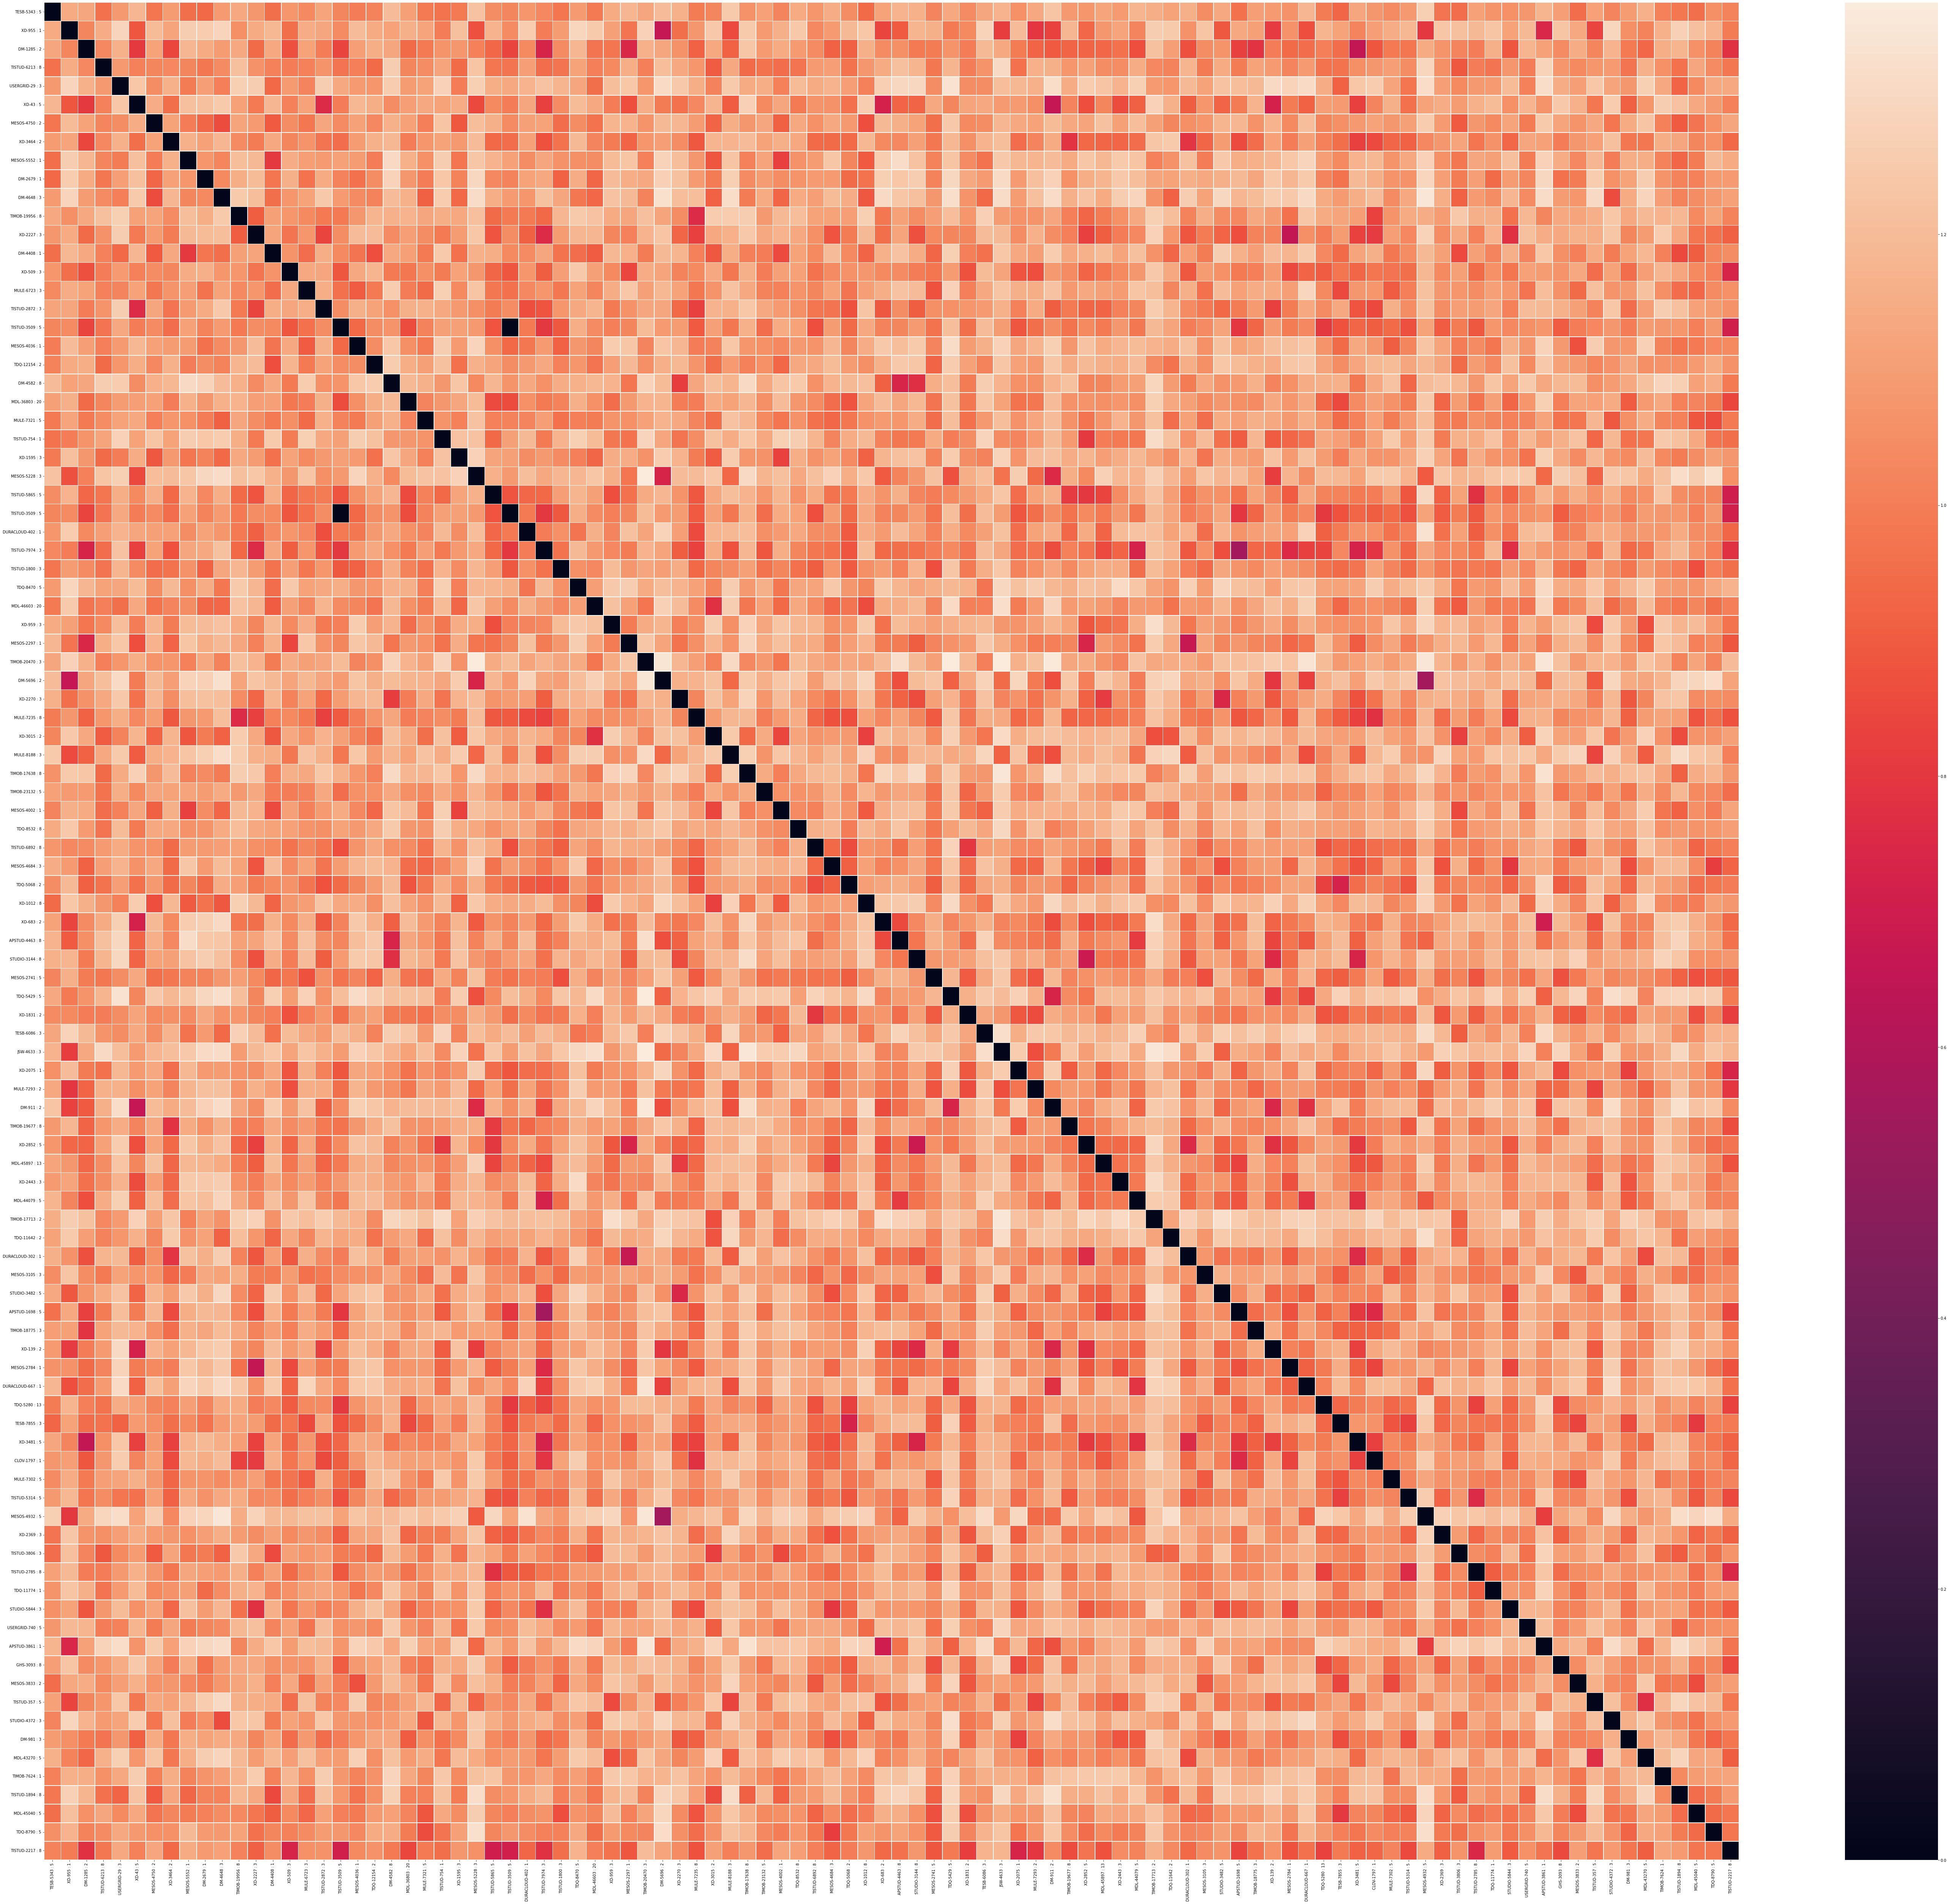

In [ ]:
fig, ax = plt.subplots(figsize=(100, 90))
ax = sns.heatmap(distance_matrixx, annot=False, linewidths=.5, xticklabels=ids, yticklabels=ids)
plt.show()

In [ ]:
x = token_id

In [ ]:
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2) 

**KNN Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier  
classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  
classifier.fit(x_train, y_train)  

KNeighborsClassifier()

In [ ]:
y_pred= classifier.predict(x_test) 

**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score 
cm = confusion_matrix(y_test, y_pred)

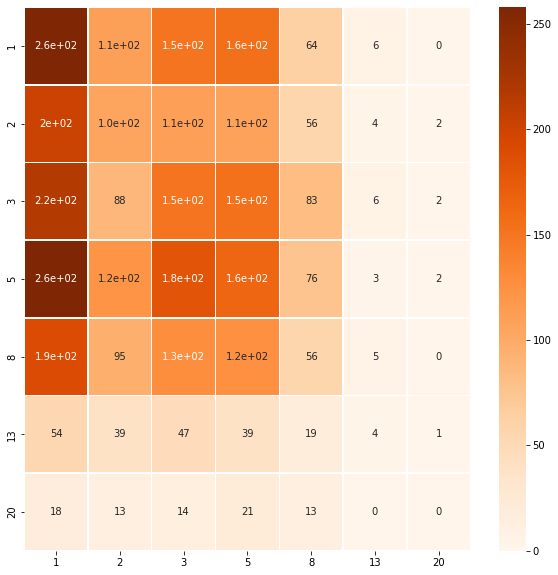

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(cm, annot=True, linewidths=.5, xticklabels=distinct_labels, yticklabels=distinct_labels,cmap='Oranges')
plt.show()

In [ ]:
accuracy_score(y_test, y_pred)

0.19854916711445458

**SVC**

In [ ]:
from sklearn.svm import SVC
classifier = SVC(gamma='auto')
classifier.fit(x_train, y_train)

SVC(gamma='auto')

In [ ]:
y_pred= classifier.predict(x_test)  

In [ ]:
cm = confusion_matrix(y_test, y_pred) 

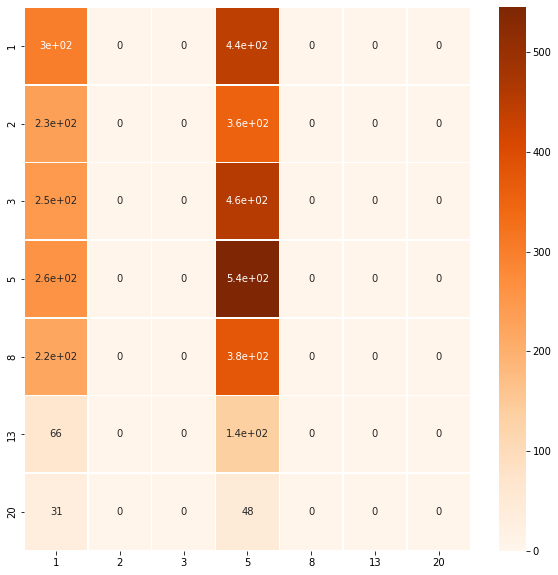

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(cm, annot=True, linewidths=.5, xticklabels=distinct_labels, yticklabels=distinct_labels,cmap='Oranges')
plt.show()

In [ ]:
accuracy_score(y_test, y_pred)

0.2275658248253627

**Decision Tree**

In [ ]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier()
classifier.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = classifier.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred) 

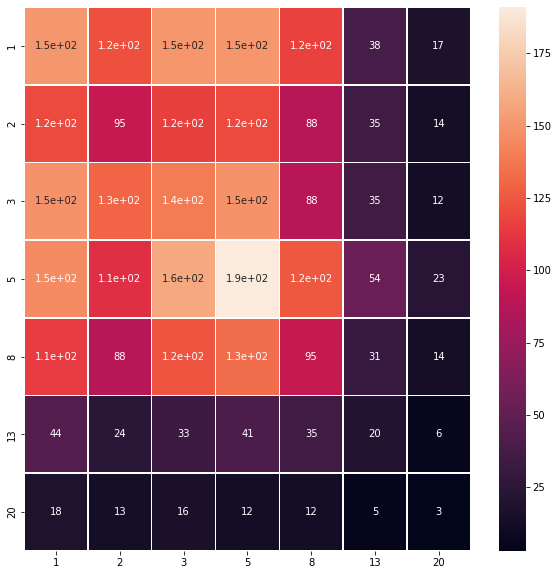

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(cm, annot=True, linewidths=.5, xticklabels=distinct_labels, yticklabels=distinct_labels)
plt.show()

In [ ]:
accuracy_score(y_test, y_pred)

0.18645889306824287

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
accuracy_list = []

for i in range (1,10):
  classifier = RandomForestClassifier(n_estimators=i, max_samples=0.6, max_features=20)
  classifier.fit(x_train, y_train)

  y_pred = classifier.predict(x_test)

  accuracy_list.append(accuracy_score(y_test, y_pred))

Text(0.5, 1.0, 'Accuracy with respect no.of trees')

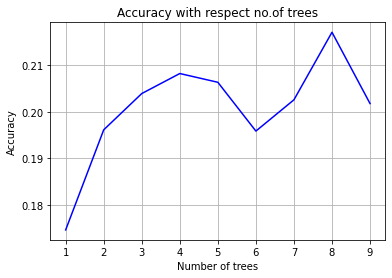

In [ ]:
plt.plot(range(1, 10), accuracy_list, color ='blue')
plt.grid()
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.title("Accuracy with respect no.of trees")

In [ ]:
accuracy_list = []

for i in range (1,50):
  classifier = RandomForestClassifier(n_estimators=50, max_samples=0.6, max_features=i)
  classifier.fit(x_train, y_train)

  y_pred = classifier.predict(x_test)

  accuracy_list.append(accuracy_score(y_test, y_pred))

Text(0.5, 1.0, 'Accuracy with respect no.of features')

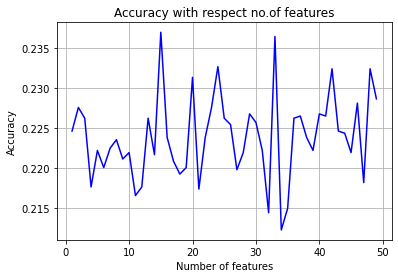

In [ ]:
plt.plot(range(1, 50), accuracy_list, color ='blue')
plt.grid()
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Accuracy with respect no.of features")